In [1]:
# Import python libraries

from qutip import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define circuit parameters 

# Define number of fock states in resonator
N = 20

# Circuit parameters
wr = 7.062 * 2 * np.pi      # Resonator frequency (7.062 GHz)[from reference]
wq = 5.092 * 2 * np.pi      # Qubit frequency (5.092 GHz)[from reference]
delta = abs(wr - wq)        # Detuning between qubit and resonator (1.97 GHz)[from reference]
k = 0.00535 * 2 * np.pi     # Resonator decay rate (5.35 MHz)[from reference]
g = 0.1029 * 2 * np.pi      # Coupling strength (102.9 MHz)[from reference]
gamma_1 = 0.001 * 2 * np.pi   # Qubit decay (0.1 MHz) [self-defined, not from reference]
gamma_2 = 0.001 * 2 * np.pi   # Qubit dephase (0.1 MHz) [self-defined, not from reference]

wr_d = wr - g**2 / delta    # Dressed resonator frequency (9.9997 GHz)
wq_d = wq + g**2 / delta    # Dressed qubit frequency (5.0003 GHz)
wd = wr

alpha = 0.157 * 2 * np.pi   # Anharmonity (157 MHz) [Chosen to align results]
K = alpha * (g/delta)**4      # Kerr self-nonlinearity (8.18 KHz) [Derived from Yvonne reference]
chi = 2 * alpha * (g/delta)**2 # Dispersive shift, cross non-linearity (5.378 MHz) [Derived from Yvonne reference]

n_crit = (delta / 2*g)**2  # Critical photon number (16)

# Define quantum operators
a = tensor(destroy(N), qeye(2))    # Resonator lowering operator
q = tensor(qeye(N), destroy(2))    # Qubit lowering operator
# Define qubit Pauli operators in composite space
sx = tensor(qeye(N), sigmax())
sy = tensor(qeye(N), sigmay())
sz = tensor(qeye(N), sigmaz())

# Base Hamiltonian without drive (lab frame):
wr_d = 0.5 * (wr + wq - np.sqrt(delta**2 + 4 * g**2))
wq_d = 0.5 * (wr + wq + np.sqrt(delta**2 + 4 * g**2))
Ka = -0.5 * alpha * (g/delta)**4 
Kb = -alpha
chi = - 2 * (g**2 * alpha) / (delta * (delta - alpha))
# H0 = wq_d * q.dag() * q + wr_d * a.dag() * a  + Kb/2 * q.dag() * q.dag() * q * q + Ka/2 * a.dag() * a.dag() * a * a + chi * (q.dag()*q) * (a.dag()*a)  # Dispersive Hamiltonian
H0 = (wr + chi * sz) * a.dag() * a + (wq)/2 * sz

drive_power = 4.984375000000001e-05 * 2 * np.pi

# Define collapse operators
c_ops = [np.sqrt(k) * a]  # Resonator decay

# Define measurement operators
e_ops = [a]  # Photon number in resonator and qubit state, resonator field

# Initial state: resonator in vacuum, qubit in ground state
psi0 = tensor(basis(N, 0), basis(2,0))  # Vacuum state for resonator, ground state for qubit
psi1 = tensor(basis(N, 0), basis(2,1))  # Vacuum state for resonator, excited state for qubit
psi4 = tensor(coherent(N, 4), basis(2,0))  # Coherent state (eigenvalue 4) for resonator, ground state for qubit
psis = tensor(basis(N,0), (basis(2,0) + basis(2,1)).unit())  # Superposition of ground and excited state for qubit

# Time evolution parameters
tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns

# Full CLEAR signal and photon response using optimal ring-up and ring-down times
drive_power = 4.984375000000001e-03 * 2 * np.pi

ringup1_norm = 11.58332303322993
ringdown1_norm = 1.6156046841062026
ringup1_amp = np.sqrt(ringup1_norm * drive_power)  # Amplitude of the ring-up pulse
ringdown1_amp = np.sqrt(ringdown1_norm * drive_power)  # Amplitude of the ring-down pulse

ringup2_norm = 12.242809267406063
drive_norm = 2.0615066563271975
ringdown2_norm = 14.632117912321677
ringup2_amp = np.sqrt(ringup2_norm * drive_power)  # Amplitude of the ring-up pulse
drive_amp = np.sqrt(drive_norm * drive_power)  # Amplitude of the drive pulse
ringdown2_amp = -np.sqrt(ringdown2_norm * drive_power)  # Amplitude of the ring-down pulse

optimal_ringup1_time = 47.6257865352412
optimal_ringdown1_time = 90.36540617777688
optimal_ringup2_time = 20.668371079660396
optimal_ringdown2_time = 44.48693108893437

def CLEAR_drive_pulse(t, args):
    if t<=optimal_ringup1_time:
        return ringup1_amp * np.exp(-1j * wd * t) * 1j * np.sqrt(k)
    elif t <= optimal_ringup1_time + optimal_ringdown1_time:
        return ringdown1_amp * np.exp(-1j * wd * t) * 1j * np.sqrt(k)
    elif t <= 500:
        return drive_amp * np.exp(-1j * wd * t) * 1j * np.sqrt(k)
    elif t <= 500 + optimal_ringdown2_time:
        return ringdown2_amp * np.exp(-1j * wd * t) * 1j * np.sqrt(k)  # Phase shift for ring-down pulse
    elif t <= 500 + optimal_ringdown2_time + optimal_ringup2_time:
        return ringup2_amp * np.exp(-1j * wd * t) * 1j * np.sqrt(k)
    else:   
        return 0.0
    
def CLEAR_drive_conj_pulse(t, args):
    return np.conj(CLEAR_drive_pulse(t, args))

    
def square_drive_pulse(t, args):
    return drive_amp * np.exp(-1j * wd * t) * 1j * np.sqrt(k)  if t <= 500 else 0  # Pulse from 100 ns to 200 ns

def square_drive_conj_pulse(t, args):
    return np.conj(square_drive_pulse(t, args))

HD1_CLEAR = [a.dag(), CLEAR_drive_pulse]
HD2_CLEAR = [a, CLEAR_drive_conj_pulse]
H_CLEAR = [H0, HD1_CLEAR, HD2_CLEAR]  # Total Hamiltonian with drive

HD1_drive = [a.dag(), square_drive_pulse]
HD2_drive = [a, square_drive_conj_pulse]
H_drive = [H0, HD1_drive, HD2_drive]  # Total Hamiltonian with drive

def CLEAR_pulse(t, args):
    if t<=optimal_ringup1_time:
        return ringup1_amp * np.cos(wd * t) * 1j * 1j * np.sqrt(k)
    elif t <= optimal_ringup1_time + optimal_ringdown1_time:
        return ringdown1_amp * np.cos(wd * t) * 1j * 1j * np.sqrt(k)
    elif t <= 500:
        return drive_amp * np.cos(wd * t) * 1j * 1j * np.sqrt(k)
    elif t <= 500 + optimal_ringdown2_time:
        return ringdown2_amp * np.cos(wd * t) * 1j * 1j * np.sqrt(k)
    elif t <= 500 + optimal_ringdown2_time + optimal_ringup2_time:
        return ringup2_amp * np.cos(wd * t) * 1j * 1j * np.sqrt(k)
    else:   
        return 0.0

def drive_pulse(t, args):
    return drive_amp * np.cos(wd * t) * 1j * 1j * np.sqrt(k) if t <= 500 else 0  # Pulse from 100 ns to 200 ns

HD_CLEAR = [(a.dag() - a), CLEAR_pulse]
HD_drive = [(a.dag() - a), drive_pulse]

H_drive2 = [H0, HD_drive]  # Total Hamiltonian with drive
H_CLEAR2 = [H0, HD_CLEAR]  # Total Hamiltonian with drive

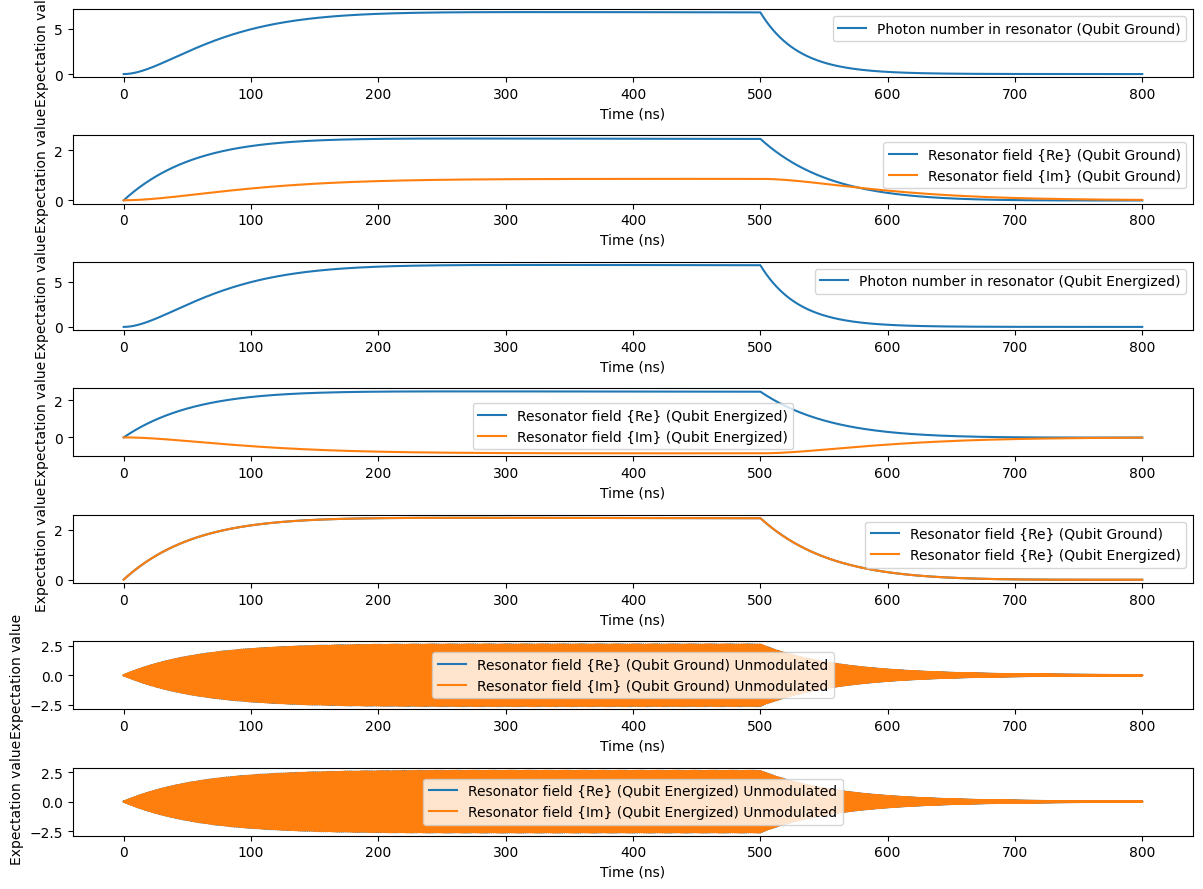

In [ ]:
# Calculate the expectation values of the measurement operators
expectations_g = mesolve(H_drive, psi0, tlist, c_ops, e_ops)
expectations_e = mesolve(H_drive, psi1, tlist, c_ops, e_ops)


# Extract the expectation values
a_expect_g = expectations_g.expect[0]
a_expect_e = expectations_e.expect[0]

a_demod_g = a_expect_g * np.exp(1j * wd * tlist)
a_demod_e = a_expect_e * np.exp(1j * wd * tlist)
n_photons_g = np.abs(a_demod_g)**2
n_photons_e = np.abs(a_demod_e)**2


# Plot the results
plt.figure(figsize=(12, 9))

plt.subplot(7, 1, 1)
plt.plot(tlist, n_photons_g, label='Photon number in resonator (Qubit Ground)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(7, 1, 2)
plt.plot(tlist, np.real(a_demod_g), label='Resonator field {Re} (Qubit Ground)')
plt.plot(tlist, np.imag(a_demod_g), label='Resonator field {Im} (Qubit Ground)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(7, 1, 3)
plt.plot(tlist, n_photons_e, label='Photon number in resonator (Qubit Energized)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(7, 1, 4)
plt.plot(tlist, np.real(a_demod_e), label='Resonator field {Re} (Qubit Energized)')
plt.plot(tlist, np.imag(a_demod_e), label='Resonator field {Im} (Qubit Energized)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(7, 1, 5)
plt.plot(tlist, np.imag(a_demod_g), label='Resonator field {Im} (Qubit Ground)')
plt.plot(tlist, np.imag(a_demod_e), label='Resonator field {Im} (Qubit Energized)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(7, 1, 6)
plt.plot(tlist, np.real(a_expect_g), label='Resonator field {Re} (Qubit Ground) Unmodulated')
plt.plot(tlist, np.imag(a_expect_g), label='Resonator field {Im} (Qubit Ground) Unmodulated')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(7, 1, 7)
plt.plot(tlist, np.real(a_expect_e), label='Resonator field {Re} (Qubit Energized) Unmodulated')
plt.plot(tlist, np.imag(a_expect_e), label='Resonator field {Im} (Qubit Energized) Unmodulated')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.tight_layout()
plt.show()

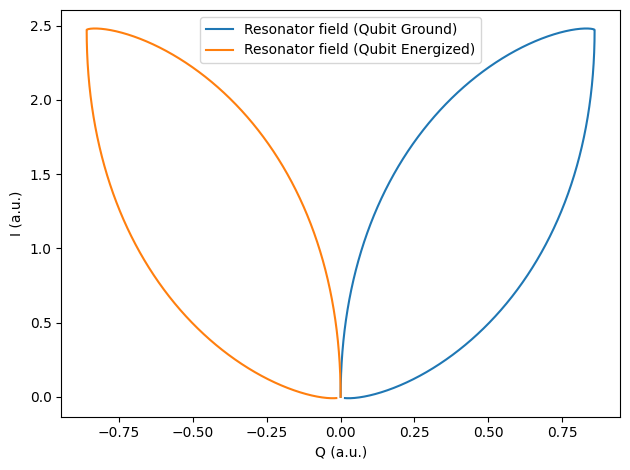

In [62]:
I_g = np.real(a_demod_g)
I_e = np.real(a_demod_e)
Q_g = np.imag(a_demod_g)
Q_e = np.imag(a_demod_e)

# Plot the results
plt.figure()

plt.plot(Q_g, I_g, label='Resonator field (Qubit Ground)')
plt.plot(Q_e, I_e, label='Resonator field (Qubit Energized)')
plt.xlabel('Q (a.u.)')
plt.ylabel('I (a.u.)')
plt.legend()

plt.tight_layout()
plt.show()

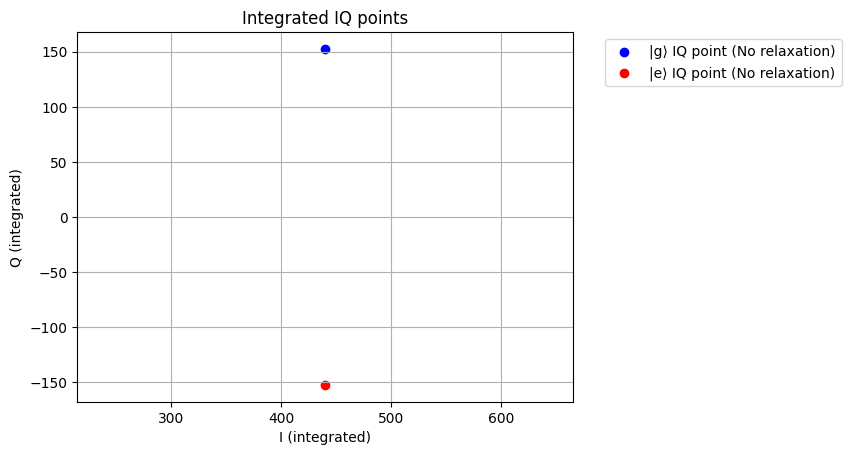

In [66]:
I_g_avg_norm = np.trapz(I_g[3220:5000], tlist[3220:5000])
Q_g_avg_norm = np.trapz(Q_g[3220:5000], tlist[3220:5000])

I_e_avg_norm = np.trapz(I_e[3220:5000], tlist[3220:5000])
Q_e_avg_norm = np.trapz(Q_e[3220:5000], tlist[3220:5000])

plt.figure()
plt.scatter(I_g_avg_norm, Q_g_avg_norm, label='|g⟩ IQ point (No relaxation)', color='blue')
plt.scatter(I_e_avg_norm, Q_e_avg_norm, label='|e⟩ IQ point (No relaxation)', color='red')
plt.xlabel("I (integrated)")
plt.ylabel("Q (integrated)")
plt.title("Integrated IQ points")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axis('equal')
plt.grid()
plt.show()

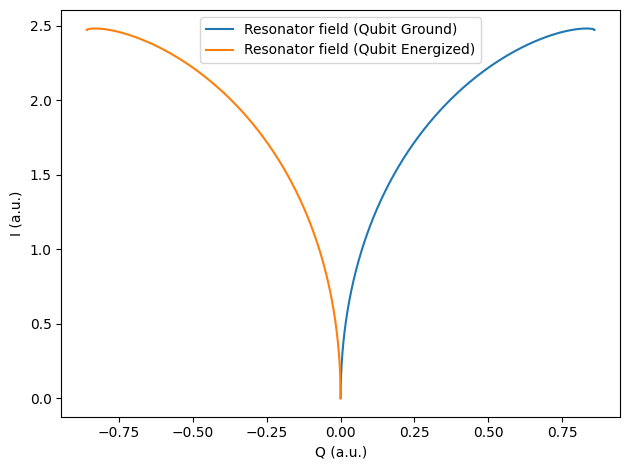

In [115]:
def const_drive_pulse(t, args):
    return drive_amp * np.exp(-1j * wd * t) * 1j * np.sqrt(k)  # Pulse from 100 ns to 200 ns

def const_drive_conj_pulse(t, args):
    return np.conj(const_drive_pulse(t, args))

H_const_drive = [a.dag(), const_drive_pulse]
H_const_conj_drive = [a, const_drive_conj_pulse]
H_const_drive = [H0, H_const_drive, H_const_conj_drive]  # Total Hamiltonian with drive

# Calculate the expectation values of the measurement operators
states_g = mesolve(H_const_drive, psi0, tlist, c_ops)
states_e = mesolve(H_const_drive, psi1, tlist, c_ops)

a_expect_g = expect(a, states_g.states)
a_expect_e = expect(a, states_e.states)

a_demod_g = a_expect_g * np.exp(1j * wd * tlist)
a_demod_e = a_expect_e * np.exp(1j * wd * tlist)
I_g = np.real(a_demod_g)
I_e = np.real(a_demod_e)
Q_g = np.imag(a_demod_g)
Q_e = np.imag(a_demod_e)

# Plot the results
plt.figure()

plt.plot(Q_g, I_g, label='Resonator field (Qubit Ground)')
plt.plot(Q_e, I_e, label='Resonator field (Qubit Energized)')
plt.xlabel('Q (a.u.)')
plt.ylabel('I (a.u.)')
plt.legend()

plt.tight_layout()
plt.show()

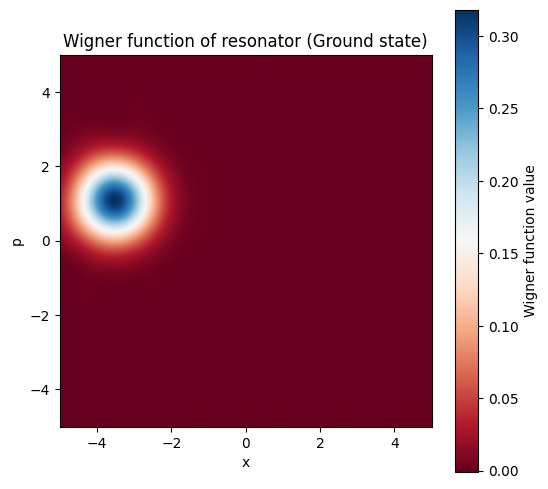

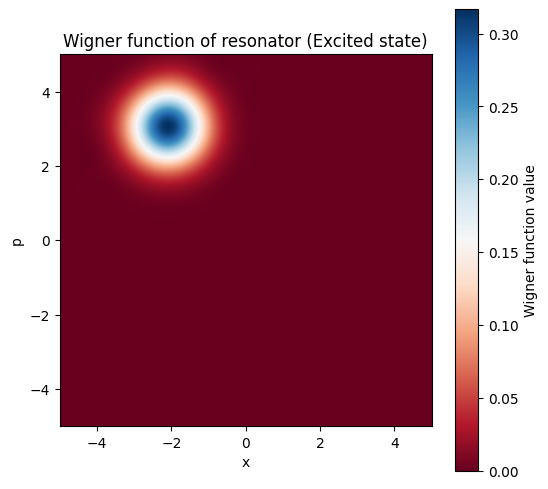

In [116]:
state_res_g = states_g.states[-1].ptrace(0)
state_res_e = states_e.states[-1].ptrace(0)

xvec = np.linspace(-5, 5, 500)

W_g = wigner(state_res_g, xvec, xvec)
plt.figure(figsize=(6, 6))
plt.imshow(W_g, extent=[-5, 5, -5, 5], cmap='RdBu', origin='lower')
plt.colorbar(label='Wigner function value')
plt.title("Wigner function of resonator (Ground state)")
plt.xlabel('x')
plt.ylabel('p') 

W_e = wigner(state_res_e, xvec, xvec)
plt.figure(figsize=(6, 6))
plt.imshow(W_e, extent=[-5, 5, -5, 5], cmap='RdBu', origin='lower')
plt.colorbar(label='Wigner function value')
plt.title("Wigner function of resonator (Excited state)")
plt.xlabel('x')
plt.ylabel('p')

plt.show()

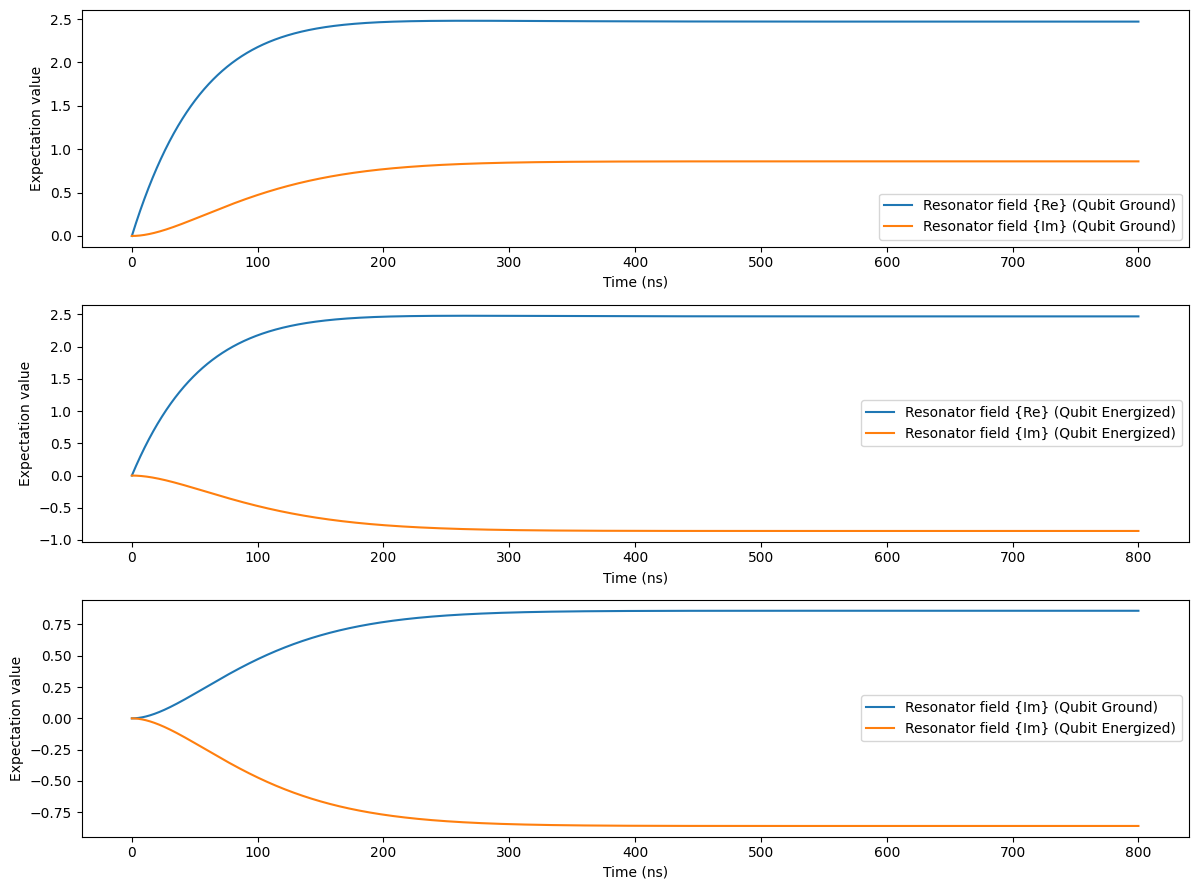

In [119]:
a_expect_g = expect(a, states_g.states)
a_expect_e = expect(a, states_e.states)
# Plot the results
plt.figure(figsize=(12, 9))

plt.subplot(3, 1, 1)
plt.plot(tlist, np.real(a_demod_g), label='Resonator field {Re} (Qubit Ground)')
plt.plot(tlist, np.imag(a_demod_g), label='Resonator field {Im} (Qubit Ground)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(tlist, np.real(a_demod_e), label='Resonator field {Re} (Qubit Energized)')
plt.plot(tlist, np.imag(a_demod_e), label='Resonator field {Im} (Qubit Energized)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(tlist, np.imag(a_demod_g), label='Resonator field {Im} (Qubit Ground)')
plt.plot(tlist, np.imag(a_demod_e), label='Resonator field {Im} (Qubit Energized)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.tight_layout()
plt.show()

/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


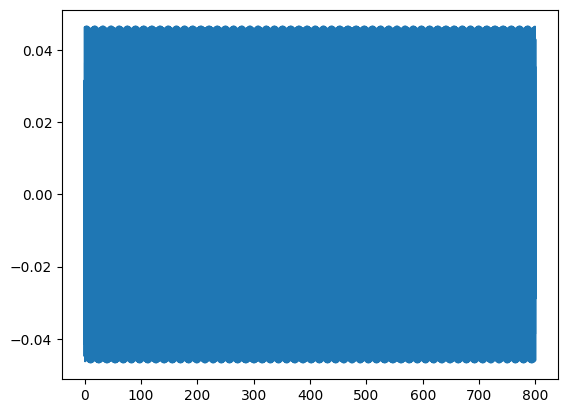

In [ ]:
wf = drive_amp * np.exp(-1j * wd * tlist) * 1j * np.sqrt(k) 
plt.plot(tlist, wf)